In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt  
import seaborn as sns
import functools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score






//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 0.1 Unzipping the file and extracting data into Pandas dataframes

In [5]:
#unzip file
z = zipfile.ZipFile('caltrans_full_survey.zip')

#get households, places, persons, and vehicles as dataframes
#households = pd.read_csv(z.open('caltrans_full_survey/survey_households.csv'), low_memory=False)
#places = pd.read_csv(z.open('caltrans_full_survey/survey_place.csv'), low_memory=False)
#persons = pd.read_csv(z.open('caltrans_full_survey/survey_person.csv'), low_memory=False)
#vehicles = pd.read_csv(z.open('caltrans_full_survey/survey_vehicles.csv'), low_memory=False)


households = pd.read_csv('../caltrans_full_survey/survey_households.csv')
places = pd.read_csv('../caltrans_full_survey/survey_place.csv')
persons = pd.read_csv('../caltrans_full_survey/survey_person.csv')
vehicles = pd.read_csv('../caltrans_full_survey/survey_vehicles.csv')
len(households)

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (9,46,50,51,102,105,120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


42426

### 0.2 Breakdown the California travel data into only Bay Area travel data

In [6]:
#limit households, places, persons, and vehicles to the Bay Area
households_ba = households[households.home_county_id.isin([1, 13, 41, 55, 75, 81, 85, 95, 97])]
places_ba = places[places.sampno.isin(households_ba.sampno)]
persons_ba = persons[persons.sampno.isin(households_ba.sampno)]
vehicles_ba = vehicles[vehicles.sampno.isin(households_ba.sampno)]

In [6]:
#find the top 25 various travel modes with their descriptions:
"""FROM DATA DICTIONARY
Travel mode:
1- Walk;
2- Bike;
3- Wheelchair/mobility scooter;
4- Other non-motorized;
5- Auto/van/truck driver;
6- Auto/van/truck passenger;
7- Carpool/vanpool;
8- Motorcycle/scooter/moped;
9- Taxi/hired car/limo;
10- Rental car/vehicle;
11- Private shuttle (Super shuttle, employer, hotel, etc.);
12- Greyhound bus;
13- Plane;
14- Other private transit;
15- Local bus, rapid bus;
16- Express bus/commuter bus (AC Transbay, Golden Gate Transit, etc.);
17- Premium bus (Metro Orange/Silver Line);
18- School bus;
19- Public transit shuttle (DASH, Emery Go Round, etc.);
20- AirBART/LAX FlyAway;
21- Dial-a-ride/paratransit (access services, etc.);
22- Amtrak bus;
23- Other bus;
24- BART, Metro Red/Purple Line;
25- ACE, Amtrak, Cal- train, Coaster, Metrolink;
26- Metro Blue/Green/Gold Line, Muni Metro, Sacramento Light Rail, San Diego Sprinter/Trolley/Orange/ Blue/Green, VTA light rail;
27- Streetcar/cable car,
28- Other rail;
29- Ferry/boat;
99- RF
"""
print("modes of transit = \n{}".format(places_ba['mode'].value_counts().head(25)))



#find the top 25 various vehicle types:
"""
Vehicle type: 1- Hybrid vehicle;
2- Gasoline-only vehicle;
3- Diesel-only vehicle;
4- Plug-in hybrid electric vehicle;
5- CNG,
6- Electric only;
7- Other;
9- DK/RF
"""
print("within cars, type of vehicle = \n{}".format(vehicles_ba['veh_type'].value_counts().head(25)))


modes of transit = 
5     50139
6     18632
1     15924
2      2244
15     1635
24     1444
7       566
26      459
8       299
25      293
18      276
11      243
10      199
13      177
16      164
9       151
4       112
14      104
29       66
27       65
28       58
3        52
19       41
21       32
23       22
Name: mode, dtype: int64
within cars, type of vehicle = 
2    15799
1     1145
3      342
6       94
7       54
4       42
5       20
9        1
Name: veh_type, dtype: int64


We can see that the bulk of all transit being taken is by auto/van/truck driving, and within that, the bulk of the auto/van/trucks are gasoline-only vehicles.

### 1.1  Households dataset - trimming

In [90]:
print(households_ba.columns)
#remove irrelevant columns for our analysis
unnecessary_columns = ['recruite', 'incentive', 'sample_type', 'cec_sample', 'non_relative_flag',
                       'strata', 'mpo_sample', 'mtc_finalflag','buyer1', 'home_state_id',
                       'buyer2', 'buyer3', 'buyer4', 'buyer5', 'buyer6', 'buyer7', 'buyer8',
                       'ldper1', 'ldper2', 'ldper3', 'ldper4', 'ldper5', 'ldper6', 'ldper7',
                       'noveh3', 'noveh4', 'noveh5', 'noveh6', 'noveh7', 'noveh8', 'gps_mtc',
                       'ldper8', 'hhwgt', 'exphhwgt', 'geom', 'complete_all', 'complete_gps',
                       'sampno', 'hispanic_flag', 'assn', 'recruite_date', 'home_block_id',
                       'home_tract_id']
trimmed_households = households_ba.drop(unnecessary_columns, axis=1)
print(trimmed_households.columns)
print(trimmed_households.shape)


Index(['sampno', 'assn', 'recruite_date', 'dow', 'home_block_id',
       'home_tract_id', 'home_county_id', 'home_state_id', 'home_primarycity',
       'home_city', 'home_state', 'home_zipcode', 'home_lon', 'home_lat',
       'tenure', 'prev_city', 'prev_state', 'prev_zipcode', 'recruite',
       'retrieval', 'incentive', 'sample_type', 'cec_sample', 'gps_sample',
       'gps_type', 'strata', 'mpo_sample', 'long_distance_8w',
       'long_distance_flag', 'hispanic_flag', 'complete_all', 'complete_gps',
       'mtc_finalflag', 'gps_mtc', 'vehicle_count', 'vehicle_op_count',
       'vehicle_power_count', 'vehicle_new_power_count', 'persons_count',
       'non_relative_flag', 'worker_count', 'student_count', 'license_count',
       'bike_count', 'trip_count', 'future', 'interview_language', 'income',
       'transit_use', 'vehicle_age', 'residence_type', 'residence_type_other',
       'home_own', 'home_own_other', 'phone_line', 'long_distance', 'buyer1',
       'buyer2', 'buyer3', 'buyer4

### 1.2 Households dataset - basic statistics and types

In [8]:
#get the types of all features in households dataset
trimmed_households.head()
trimmed_households.dtypes

#get the basic statistics of all features in households dataset
basic_stats_households = pd.DataFrame({'mean': trimmed_households.mean(), 'std': trimmed_households.std(), \
                                      'min':trimmed_households.min(), 'max':trimmed_households.max()})
#trimmed_households.describe()
basic_stats_households


,max,mean,min,std
assn,13132,1.274002e+04,12532,144.468665
bike_count,99,1.761709e+00,0,3.697811
dow,7,3.620793e+00,1,1.705850
future,2,1.309727e+00,1,0.462405
gps_sample,3,1.712198e+00,1,0.794858
gps_type,3,1.149723e+00,1,0.508323
hispanic_flag,2,1.840968e+00,1,0.365725
home_block_id,REDACTED,NaN,REDACTED,NaN
home_city,YOUNTVILLE,NaN,ALAMEDA,NaN
home_county_id,97,5.710026e+01,1,36.743666


We can see that there are a few qualitative variables whose values for the basic statistics, naturally, are NaNs. We will be using these variables later in the analysis.

### 1.3 Households dataset - visualizing

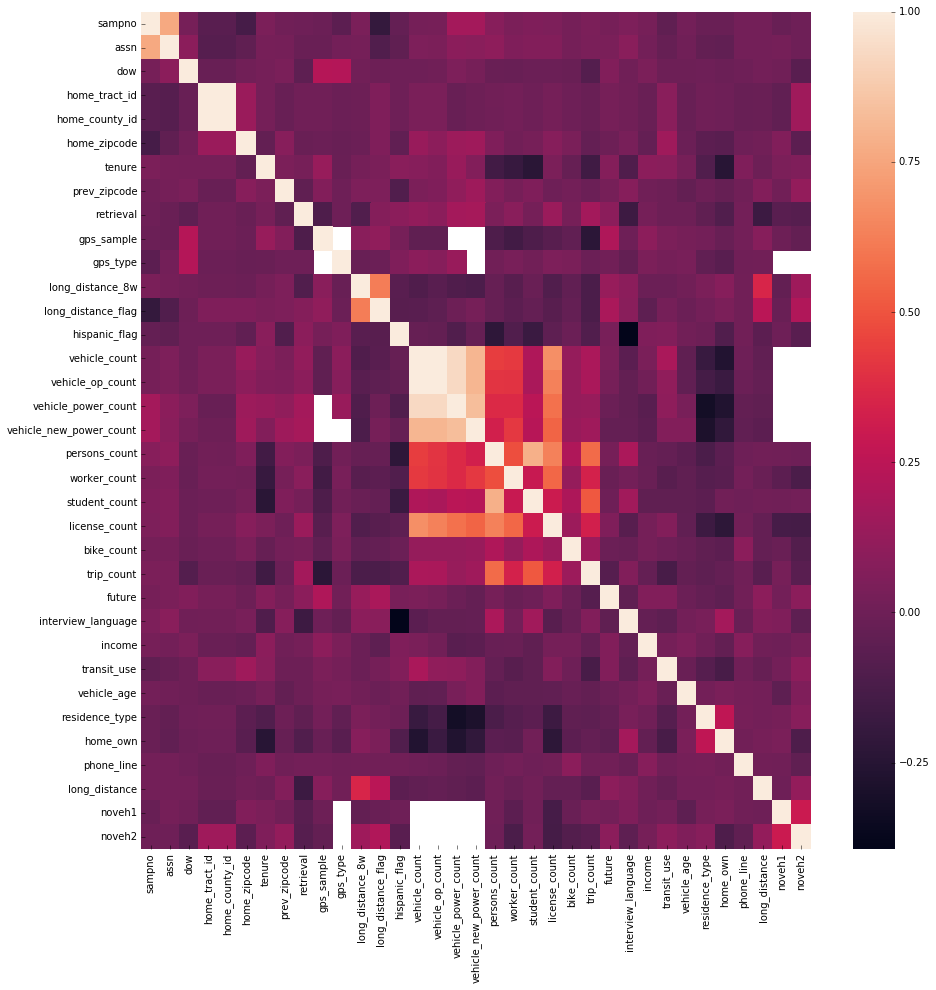

In [9]:
#do a correlation matrix of the trimmed household set
fig = plt.figure(figsize=(15, 15))
#fig = plt.figure()
axes = fig.add_subplot(111)
corrs = trimmed_households.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns)

### 2.1 Persons dataset - trimming

In [20]:
print(persons.columns)
#remove irrelevant columns for our analysis
unnecessary_columns = ['nrel_agebin', 'education_other', 'has_diary', 'race3', 'race4', 'race_other',
                       'transit_pass_t3', 'transit_pass_t4', 'transit_pass_t5', 'transit_pass_t6', 'transit_pass_t7',
                       'transit_pass_other', 'clipper_card_t1', 'clipper_card_t2', 'clipper_card_t3', 'compass_card',
                       'typs_ex_pass_card', 'empl_status_other', 'empl_industry_other', 'empl_occupation_other',
                       'empl_name', 'empl_state', 'empl_cross_street1', 'empl_cross_street2', 'empl_block_id',
                       'empl_tract_id', 'empl_state_id', 'empl_county_id', 'empl_lon', 'empl_lat', 'workday_mon',
                       'workday_tue', 'workday_wed', 'workday_thurs', 'workday_fri', 'workday_sat', 'workday_sun',
                       'workday_flex', 'workday_flex_opt', 'empl_sec_loc', 'empl_sec_name', 'empl_sec_city',
                       'empl_sec_zipcode', 'empl_sec_state', 'empl_sec_state_id', 'empl_sec_primarycity',
                       'empl_sec_cross_street1', 'empl_sec_cross_street2', 'workday_sec_count', 'dis_type3',
                       'dis_type4', 'dis_type5', 'dis_type6', 'dis_type7', 'dis_other', 'dis_lis_plate', 'dis_reg',
                       'school_grade_other', 'school_home', 'school_pre', 'school_pre_other', 'school_name',
                       'school_city', 'school_zipcode', 'school_state', 'school_cross_street1', 'school_cross_street2',
                       'school_block_id', 'school_tract_id', 'school_county_id', 'school_state_id', 'school_primarycity',
                       'school_lon', 'school_lat', 'transit_subsidy', 'transit_subsidy_amt', 'transit_subsidy_unit',
                       'transit_subsidy_unit_other', 'interview', 'interview_proxy', 'interview_log_complete',
                       'toll_road3', 'toll_road4', 'toll_road5', 'toll_road6', 'toll_road7', 'toll_road8',
                       'toll_road9', 'toll_road10', 'toll_bridge3', 'toll_bridge4', 'toll_bridge5', 'toll_bridge6',
                       'toll_bridge7', 'toll_bridge8', 'toll_bridge9', 'toll_bridge10', 'why_no_trips_other',
                       'incomplete', 'perwgt', 'expperwgt', 'geom', 'sampno', 'hispanic_flag']
trimmed_persons = persons_ba.drop(unnecessary_columns, axis=1)
print(trimmed_persons.columns)
print(trimmed_persons.shape)


Index(['sampno', 'perno', 'vehno', 'travel_date', 'relation', 'gender', 'age',
       'nrel_agebin', 'education', 'education_other',
       ...
       'toll_bridge8', 'toll_bridge9', 'toll_bridge10', 'hov_lane',
       'why_no_trips', 'why_no_trips_other', 'incomplete', 'perwgt',
       'expperwgt', 'geom'],
      dtype='object', length=152)
Index(['perno', 'vehno', 'travel_date', 'relation', 'gender', 'age',
       'education', 'person_trips', 'walk_trips', 'bike_trips', 'motor_trip',
       'race1', 'race2', 'citizen', 'country_birth', 'driver_license',
       'transit_pass', 'transit_pass_t1', 'transit_pass_t2', 'toll_pass',
       'car_sharing', 'employment', 'empl_status', 'empl_industry',
       'empl_occupation', 'empl_loc_type', 'empl_city', 'empl_zipcode',
       'empl_primarycity', 'workday_count', 'hour_per_week', 'commute_mode',
       'job_count', 'disabled', 'dis_type1', 'dis_type2', 'student',
       'school_mode', 'school_grade', 'school_online', 'transit_trip',
       

### 2.2 Persons dataset - basic statistics and types

In [12]:
#get the types of all features in persons dataset
trimmed_persons.head()
trimmed_persons.dtypes

#get the basic statistics of all features in persons dataset
basic_stats_persons = pd.DataFrame({'mean': trimmed_persons.mean(), 'std': trimmed_persons.std(), \
                                      'min':trimmed_persons.min(), 'max':trimmed_persons.max()})
#trimmed_persons.describe()
basic_stats_persons

,max,mean,min,std
age,REDACTED,NaN,REDACTED,NaN
bike_trips,99,3.024788,0,13.605034
car_sharing,9,2.009035,1,0.449909
citizen,9,1.202989,1,0.585213
commute_mode,99,6.924342,1,5.820453
country_birth,9999,2774.229022,1919,2385.320605
dis_type1,99,30.067809,1,42.236533
dis_type2,98,25.552189,1,39.068523
disabled,9,1.962991,1,0.445913
driver_license,9,1.107163,1,0.442123


### 2.3 - Persons dataset - visualizing

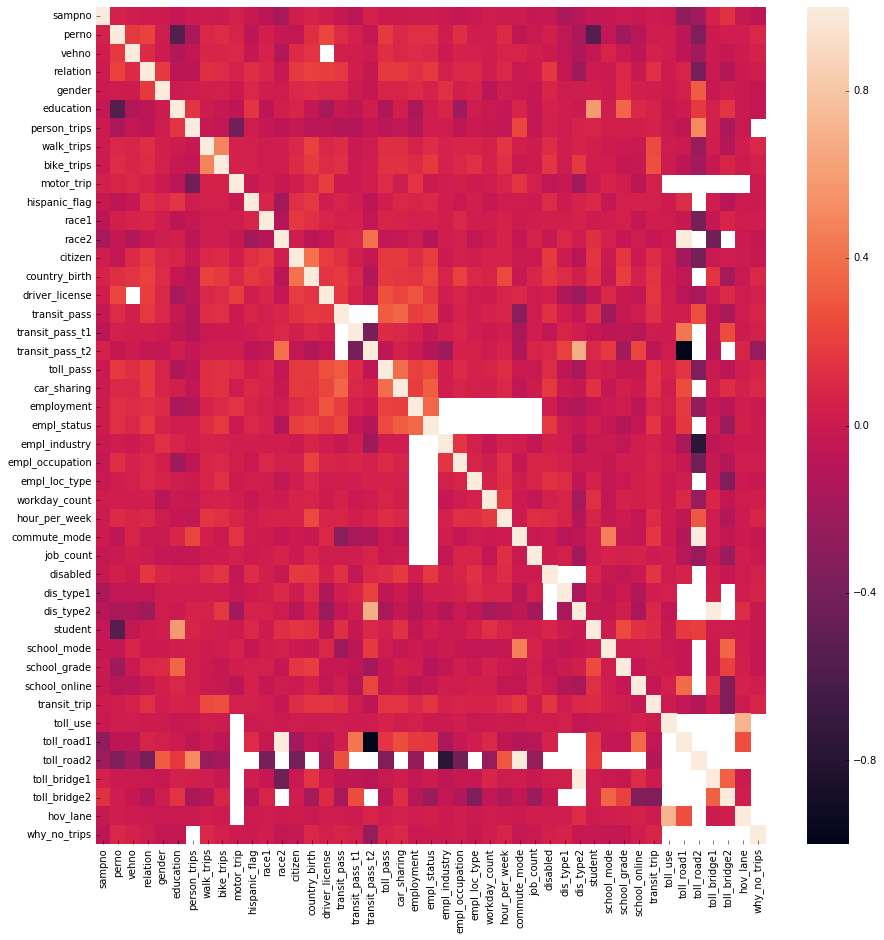

In [13]:
#do a correlation matrix of the trimmed persons set
fig = plt.figure(figsize=(15, 15))
#fig = plt.figure()
axes = fig.add_subplot(111)
corrs = trimmed_persons.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns)

### 3.1 Places dataset - trimming

In [24]:
print(places.columns)
#remove irrelevant columns for our analysis
unnecessary_columns = ['tripno', 'air_trip_distance_miles', 'tripdistanceflag', 'block_id', 'tract_id',
                       'state_id', 'parked_other_loc_type', 'parked_address', 'parked_unit', 'parked_other_pay_type',
                       'parked_paymen_ne', 'got_out_vehicle', 'transit_system_other', 'perwgt', 'expperwgt',
                       'tcf', 'tcfperwgt', 'exptcfperwgt', 'lon', 'lat', 'route', 'per1', 'per2', 'per3', 'per4',
                       'per5', 'geom', 'perno', 'vehno', 'travel_date']

trimmed_places = places_ba.drop(unnecessary_columns, axis=1)
print(trimmed_places.columns)
print(trimmed_places.shape)


Index(['sampno', 'perno', 'plano', 'vehno', 'tripno', 'place_name',
       'travel_date', 'arr_time', 'dep_time', 'mode', 'trip_distance_miles',
       'air_trip_distance_miles', 'tripdistanceflag', 'prev_trip_duration_min',
       'act_dur', 'act_cnt', 'block_id', 'tract_id', 'county_id', 'state_id',
       'place_primarycity', 'city', 'zipcode', 'state', 'parked_loc_type',
       'parked_other_loc_type', 'parked_address', 'parked_minutes',
       'parked_payed', 'parked_amount_payed', 'parked_unit', 'parked_pay_type',
       'parked_other_pay_type', 'parked_paymen_ne', 'got_out_vehicle',
       'transit_system', 'transit_system_other', 'perwgt', 'expperwgt', 'tcf',
       'tcfperwgt', 'exptcfperwgt', 'tottr', 'hhmem', 'lon', 'lat',
       'non_hh_members', 'route', 'per1', 'per2', 'per3', 'per4', 'per5',
       'geom'],
      dtype='object')
Index(['sampno', 'plano', 'place_name', 'arr_time', 'dep_time', 'mode',
       'trip_distance_miles', 'prev_trip_duration_min', 'act_dur', 'act_

### 3.2 Places dataset - basic statistics and types

In [15]:
#get the types of all features in places dataset
trimmed_places.head()
trimmed_places.dtypes

#get the basic statistics of all features in places dataset
basic_stats_places = pd.DataFrame({'mean': trimmed_places.mean(), 'std': trimmed_places.std(), \
                                      'min':trimmed_places.min(), 'max':trimmed_places.max()})
#trimmed_places.describe()
basic_stats_places

,max,mean,min,std
act_cnt,3,1.328979,1,0.664305
act_dur,19431,278.707001,1,335.860156
arr_time,23:00:00,NaN,00:00:00,NaN
city,ZURICH,NaN,ACAMPO,NaN
county_id,999,58.961566,1,53.400895
dep_time,23:00:00,NaN,00:00:00,NaN
hhmem,6,0.632262,0,0.933532
mode,29,5.279147,1,4.039473
non_hh_members,14,0.197809,0,0.654573
parked_amount_payed,99999,209.254770,0,4290.982192


### 3.3 - Places dataset - visualizing

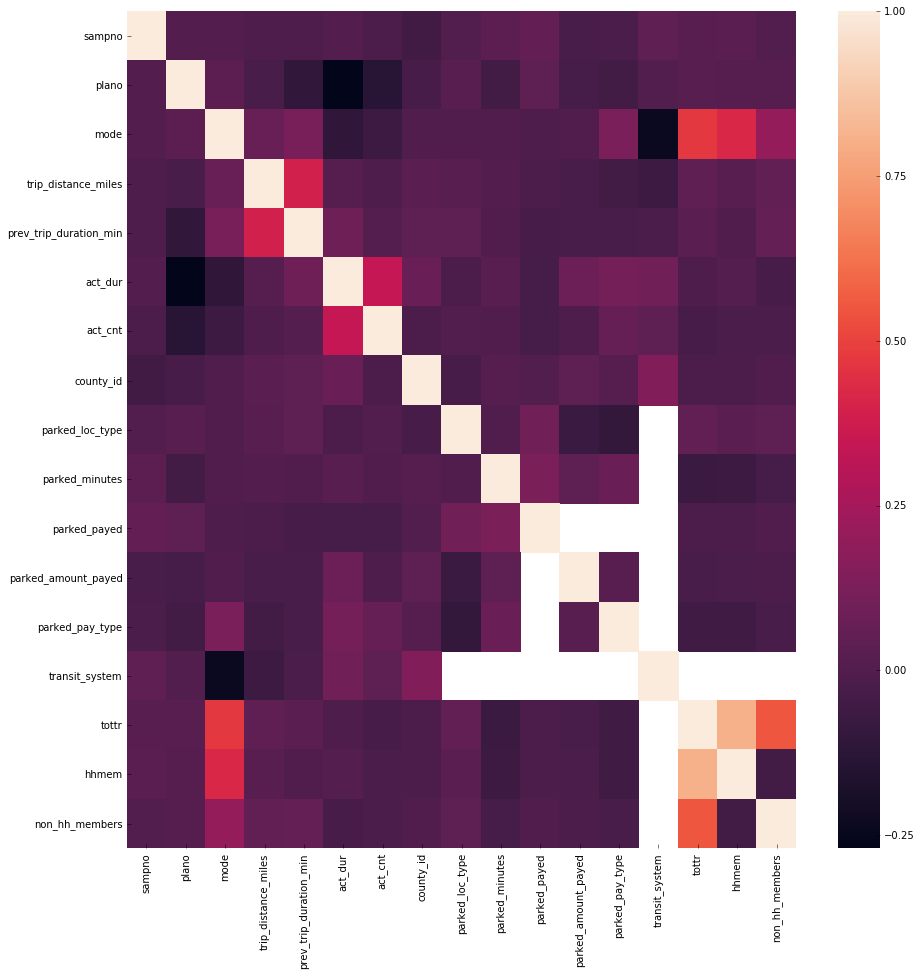

In [60]:
#do a correlation matrix of the trimmed places set
fig = plt.figure(figsize=(15, 15))
#fig = plt.figure()
axes = fig.add_subplot(111)
corrs = trimmed_places.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns)

### 4.1 Vehicles dataset - trimming

In [84]:
print(vehicles.columns)
#remove irrelevant columns for our analysis
unnecessary_columns = ['vehno', 'veh_series', 'veh_series_other', 'fuel_type2', 'fuel_type3', 'fuel_type4',
                       'fuel_type5', 'fuel_type6', 'fuel_type_other', 'outlet', 'outlet_volt', 'insurance',
                       'outlet_electric', 'obd_device', 'hhwgt', 'exphhwgt', 'geom', 'sampno', 'why_no_travel',
                       'why_no_travel_other']

trimmed_vehicles = vehicles_ba.drop(unnecessary_columns, axis=1)
print(trimmed_vehicles.columns)
print(trimmed_vehicles.shape)


Index(['sampno', 'vehno', 'veh_type', 'model_year', 'veh_make',
       'veh_make_other', 'veh_model', 'veh_series', 'veh_series_other',
       'body_type', 'body_type_other', 'transmission', 'power_train',
       'power_train_other', 'cylinders', 'cylinders_other', 'fuel_type1',
       'fuel_type2', 'fuel_type3', 'fuel_type4', 'fuel_type5', 'fuel_type6',
       'fuel_type_other', 'outlet', 'outlet_volt', 'outlet_electric',
       'purchase_type', 'ownership', 'ownership_other', 'insurance',
       'obd_device', 'vehicle_used', 'why_no_travel', 'why_no_travel_other',
       'hhwgt', 'exphhwgt', 'geom', 'epa_id'],
      dtype='object')
Index(['veh_type', 'model_year', 'veh_make', 'veh_make_other', 'veh_model',
       'body_type', 'body_type_other', 'transmission', 'power_train',
       'power_train_other', 'cylinders', 'cylinders_other', 'fuel_type1',
       'purchase_type', 'ownership', 'ownership_other', 'vehicle_used',
       'epa_id'],
      dtype='object')
(17497, 18)


### 4.2 Vehicles dataset - basic statistics and types

In [62]:
#get the types of all features in vehicles dataset
trimmed_vehicles.head()
trimmed_vehicles.dtypes

#get the basic statistics of all features in vehicles dataset
basic_stats_vehicles = pd.DataFrame({'mean': trimmed_vehicles.mean(), 'std': trimmed_vehicles.std(), \
                                      'min':trimmed_vehicles.min(), 'max':trimmed_vehicles.max()})
#trimmed_vehicles.describe()
basic_stats_vehicles

,max,mean,min,std
body_type,99,3.548094,1,7.495593
body_type_other,NaN,NaN,NaN,NaN
cylinders,99,17.248173,1,33.648750
cylinders_other,NaN,NaN,NaN,NaN
epa_id,37370,12828.417964,8,7202.126501
fuel_type1,9,1.053498,1,0.371608
fuel_type2,7,3.045369,1,0.817553
insurance,9,2.726694,1,2.264517
model_year,9999,2244.641081,1931,1370.393925
ownership,9,1.061782,1,0.448937


### 4.3 - Vehicles dataset - visualizing

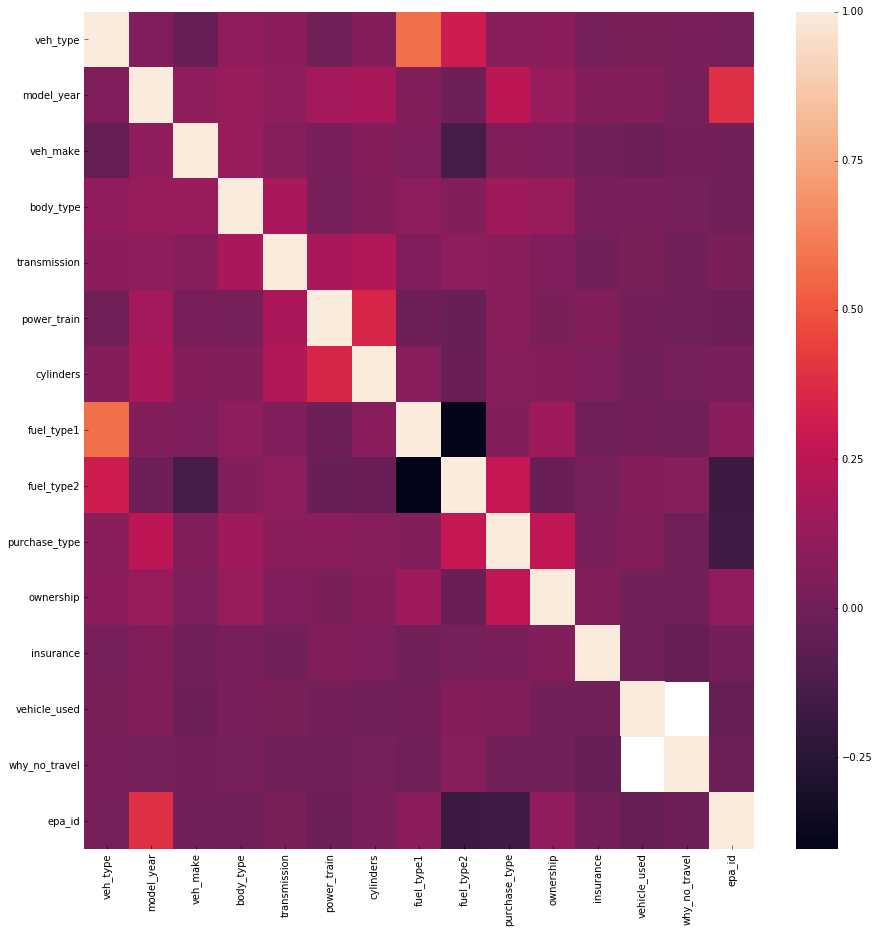

In [63]:
#do a correlation matrix of the trimmed vehicles set
fig = plt.figure(figsize=(15, 15))
#fig = plt.figure()
axes = fig.add_subplot(111)
corrs = trimmed_vehicles.corr()
sns.heatmap(corrs, 
        xticklabels=corrs.columns,
        yticklabels=corrs.columns)

### 5.1 - Joining all dataframes

In [91]:
#vehicles['veh_type']
#vehicle_type = vehicles.groupby('veh_type', as_index=False)['why_no_travel'].mean()
#vehicle_type


#data_list = [trimmed_households, trimmed_persons, trimmed_places, trimmed_vehicles]

joined_df = trimmed_households.join(trimmed_persons).join(trimmed_places).join(trimmed_vehicles)
joined_df

#df_final = functools.reduce(lambda left,right: pd.merge(left,right,on='name'), data_list)

,dow,home_county_id,home_primarycity,home_city,home_state,home_zipcode,home_lon,home_lat,tenure,prev_city,...,power_train,power_train_other,cylinders,cylinders_other,fuel_type1,purchase_type,ownership,ownership_other,vehicle_used,epa_id
17,2,85,MOUNTAIN VIEW,MOUNTAIN VIEW,CA,94040,REDACTED,REDACTED,16,NaN,...,1,NaN,5,NaN,1,1,1,NaN,1,4809
18,4,85,MOUNTAIN VIEW,MOUNTAIN VIEW,CA,94041,REDACTED,REDACTED,8,NaN,...,2,NaN,4,NaN,1,2,1,NaN,1,NaN
19,5,85,SUNNYVALE,SUNNYVALE,CA,94085,REDACTED,REDACTED,6,NaN,...,1,NaN,2,NaN,1,1,1,NaN,1,18016
20,3,85,SUNNYVALE,SUNNYVALE,CA,94086,REDACTED,REDACTED,3,CAMPBELL,...,1,NaN,3,NaN,1,2,1,NaN,1,4944
21,5,85,SUNNYVALE,SUNNYVALE,CA,94086,REDACTED,REDACTED,20,NaN,...,2,NaN,2,NaN,1,2,1,NaN,1,15470
22,2,85,SUNNYVALE,SUNNYVALE,CA,94087,REDACTED,REDACTED,5,SONORA,...,1,NaN,4,NaN,1,2,1,NaN,2,NaN
23,7,85,SUNNYVALE,SUNNYVALE,CA,94087,REDACTED,REDACTED,24,NaN,...,3,NaN,4,NaN,1,2,1,NaN,1,4944
24,4,85,PALO ALTO,PALO ALTO,CA,94301,REDACTED,REDACTED,4,MENLO PARK,...,2,NaN,4,NaN,1,2,1,NaN,2,NaN
25,3,85,PALO ALTO,PALO ALTO,CA,94303,REDACTED,REDACTED,18,NaN,...,2,NaN,2,NaN,1,1,1,NaN,2,20452
26,2,85,PALO ALTO,PALO ALTO,CA,94306,REDACTED,REDACTED,6,NaN,...,2,NaN,4,NaN,1,1,1,NaN,2,1151


### 5.2 - Split into training and test sets

In [119]:
#mode = places.groupby('mode', as_index=False)['trip_distance_miles'].mean()
#mode

#get the numerical columns
cols = joined_df.columns
num_cols = joined_df._get_numeric_data().columns #find columns with numerical data
list_cols = list(set(cols) - set(num_cols))
#print(list_cols)

#fill in all rows that contain NaNs
joined_df = joined_df.fillna(lambda x: x.median())

#set up the X and y datasets for train/test splits
X = joined_df[num_cols]
y = joined_df['veh_type']

#split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)



### 5.3 - kNN on the datasets

In [122]:
#initialize knn classifier model (k = 5)
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X_train, y_train)

# predict the target values
pred = knn.predict(X_test)

# evaluate its accuracy
print(accuracy_score(y_test, pred))



0.938864628821


In [36]:
#print the types of modes


# set up training and test data
train_idx = np.random.choice(range(len(places_ba)), int(len(places_ba) * .8), replace=False)
test_idx = list(set(range(len(places_ba))) - set(list(train_idx)))

train_v_names = list(set(places_ba.columns.tolist()))
#print(train_v_names)
train_v_names_target = list(set(persons.columns.tolist()))
#print(train_v_names_target)
bdata_train = places_ba.loc[train_idx, train_v_names]
bdata_test = places_ba.loc[test_idx, train_v_names]
train_target = persons.loc[train_idx, 'school_primarycity']
#print(train_medv)
test_target = persons.loc[test_idx, 'school_primarycity']

